# Projet Réseaux de Neurones – IMSD - 2019-2020

Données S&P 500 de l'API Google Finance. 
Les données comprennent l'indice ainsi que les cours des actions des 500 constituants du S&P. 
L'idée est de développer un modèle d'apprentissage en profondeur pour prédire l'indice S&P 500 sur la base des prix des 500 constituants (actions).

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import *
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

!pip install xgboost
!pip install lightgbm
!pip install catboost

import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
print(tf.__version__)

1.13.1


In [2]:
data = pd.read_csv(r"C:\Users\33627\Documents\IMSD 2019-2020\IMSD S2\Réseaux de neurones\data_stocks.csv")
data.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


# Partie 1: Analyse exploratoire (SP500)

Nombre de lignes du dataframe: 41266 
Nombre de colonnes du dataframe: 502

Nombre d'entreprises cotées NASDAQ : 123
Nombre d'entreprises cotées NYSE : 377

Les données manquantes: False


***********************************************************************
Statistiques descriptives annuelle
          SP500                                                          
            min        max         mean          var        std      skew
year                                                                     
2017  2329.1399  2490.6499  2421.537882  1564.766925  39.557135 -0.422508
kurtosis -0.8120900844367198


***********************************************************************
Statistiques descriptives mensuelle
           SP500                                                         
             min        max         mean         var        std      skew
month                                                                    
4      2329.1399  2397.9299  2360.751392  299.7

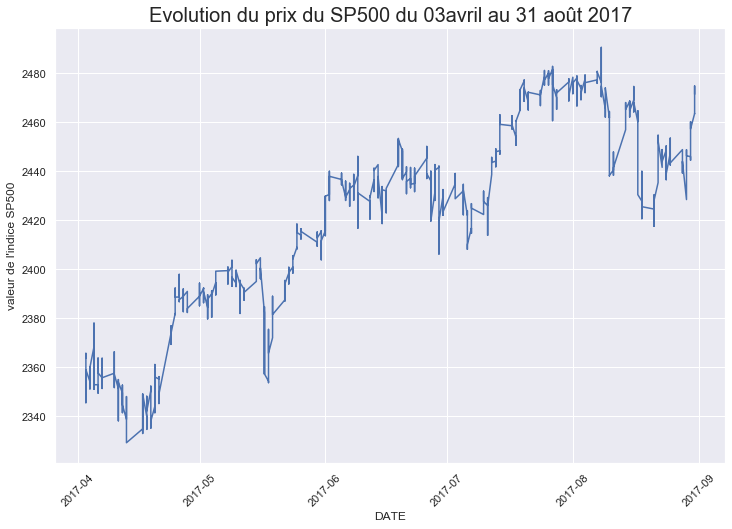

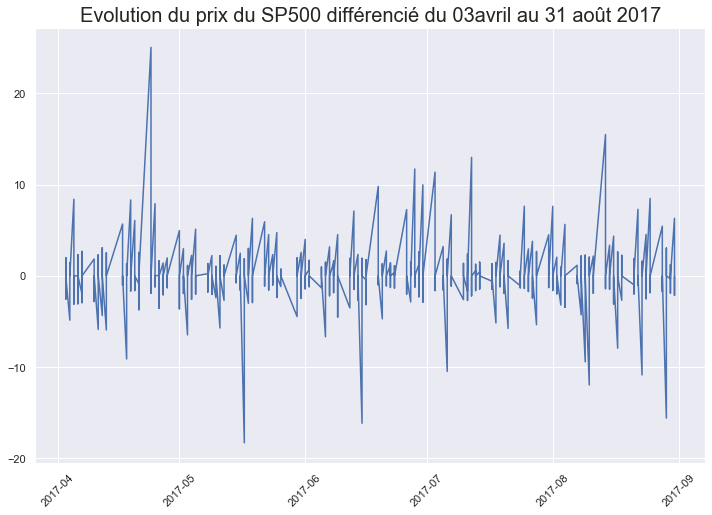

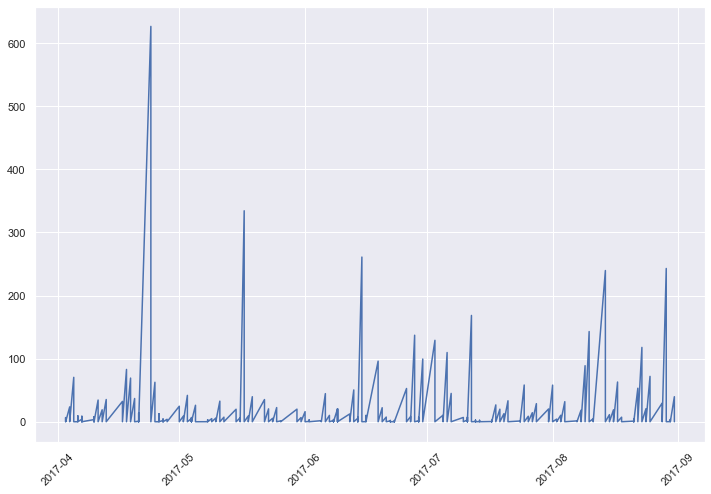

In [3]:
def analyse_exploratoire(df):
    
    """
        Fonction pour faire une analyse exploratoire 
        sur les données avec matplolib
        
    """
    
    print(f"Nombre de lignes du dataframe: {df.shape[0]} \nNombre de colonnes du dataframe: {df.shape[1]}\n")
    
    filter_col_NASDAQ = [col for col in data if col.startswith('NASDAQ')]
    filter_col_NYSE = [col for col in data if col.startswith('NYSE')]
    print(f"Nombre d'entreprises cotées NASDAQ : {len(filter_col_NASDAQ)}")
    print(f"Nombre d'entreprises cotées NYSE : {len(filter_col_NYSE)}\n")
    # les manquants
    check_for_nan = df.isnull().values.any()
    print(f"Les données manquantes: {check_for_nan}\n\n")
    
    # formater la date 
    df.DATE = df.DATE.apply(lambda x : datetime.fromtimestamp(x))
    df.DATE = df.DATE.map(lambda x: x.strftime('%Y-%m-%d'))
    df.DATE = pd.to_datetime(df.DATE, format='%Y-%m-%d')

    # garder que SP500
    data_sd = df[["DATE", "SP500"]]
    data_sd['year'] = data_sd['DATE'].dt.year
    
    print("***********************************************************************")
    print("\033[1mStatistiques descriptives annuelle\033[0m")
    print(data_sd.groupby('year').agg(["min", "max", "mean", "var", "std", "skew"])) 
    print(f"kurtosis {data_sd.SP500.kurtosis()}\n\n")
    
    data_sd.drop("year", inplace=True, axis=1)
    data_sd['month'] = data_sd['DATE'].dt.month
    print("***********************************************************************")
    print("\033[1mStatistiques descriptives mensuelle\033[0m")
    print(data_sd.groupby('month').agg(["min", "max", "mean", "var", "std", "skew"])) 
    print(f"kurtosis per {data_sd.groupby(['month'])['SP500'].apply(pd.DataFrame.kurt)}\n\n")
    
    print("***********************************************************************")
    print("\033[1mQuartiles\033[0m")
    print(f"{data_sd.SP500.describe()}\n\n")
    
    print("***********************************************************************")
    #df = data[["DATE", "SP500"]]
    df['VARIATION'] = df['SP500'] - df['SP500'].shift()
    df['ECART_VARIATION_MOYENNE'] = df['VARIATION'] - df['VARIATION'].mean()
    df['CARRE_ECART'] = df['ECART_VARIATION_MOYENNE']**2
    print(f"Moyenne des carrés des écarts (Volatilité) : {df['CARRE_ECART'].mean()}")
    print(f"Ecart Type (Volatilité) : {sqrt(df['CARRE_ECART'].mean())}")
    print(f"Ecart Type (Volatilité mensualisée) : {(sqrt(df['CARRE_ECART'].mean())*sqrt(5))}\n\n")
    
    print("***********************************************************************")
    # le graphique
    data_sd = data_sd.set_index("DATE")
    
    plt.figure(figsize=(12,8))
    plt.plot(data_sd.SP500)
    plt.title("Evolution du prix du SP500 du 03avril au 31 août 2017", fontsize=20)
    plt.ylabel("valeur de l'indice SP500")
    plt.xlabel("DATE")
    plt.xticks(rotation=45)
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.plot(data_sd['SP500'].diff())
    plt.title("Evolution du prix du SP500 différencié du 03avril au 31 août 2017", fontsize=20)
    plt.xticks(rotation=45)
    plt.show()
    
    dff = df.set_index("DATE")
    plt.figure(figsize=(12,8))
    plt.plot(dff['CARRE_ECART'])
    plt.xticks(rotation=45)
    plt.show()
    
analyse_exploratoire(data)

# Partie 2: TROIS modèles de calibration et de prévision

## a) Réseau de neurones avec tensorflow

In [4]:
class Model:
    
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, 500))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        #self.out = tf.reshape(self.logits, [batch_size, output_size])
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [5]:
def forecast(data):
    
    
    data = pd.read_csv(r"C:\Users\33627\Documents\IMSD 2019-2020\IMSD S2\Réseaux de neurones\data_stocks.csv")
    data.drop("DATE", inplace=True, axis=1)
    
    # Division des données en train test
    n = data.shape[0]
    start_test = int(np.floor(0.8 * n)) 
    train = data[data.index < start_test]
    test = data[data.index >= start_test]

    # Normaliser les données
    scaler = MinMaxScaler()
    data_train = scaler.fit_transform(train)
    data_test = scaler.transform(test)

    X_train = data_train[:, 1:]
    y_train = data_train[:, 0]
    X_test = data_test[:, 1:]
    y_test = data_test[:, 0]
    y_train = pd.DataFrame(y_train)
    X_train = pd.DataFrame(X_train)
    y_test = pd.DataFrame(y_train)
    X_test = pd.DataFrame(X_train)
    
    # initialiser les hyper-paramètres 
    num_layers = 10
    size_layer = 50
    batch_size = 256
    dropout_rate = 0.8
    learning_rate = 0.1
    
    # entrainement du model lstm
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, y_train.shape[1], size_layer, y_train.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    init_value = np.zeros((1, num_layers * 2 * size_layer))

    # Entrainement des mini lots
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_train_x = X_train[start:start + batch_size]
        batch_train_x = np.array(batch_train_x)
        batch_train_x = batch_train_x.reshape((-1, batch_size, 500))
        batch_train_y = y_train[start:start + batch_size]
        
        batch_test_x = X_test[start:start + batch_size]
        batch_test_x = np.array(batch_test_x)
        batch_test_x = batch_test_x.reshape((-1, batch_size, 500))
        batch_test_y = y_test[start:start + batch_size]
        
    total_loss = []
    for k in range(0, y_train.shape[0] - 1, batch_size):
        
        logits, last_state, _ = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer],
                feed_dict = {
                    modelnn.X: batch_train_x,
                    modelnn.Y: batch_train_y,
                    modelnn.hidden_layer: init_value,
                },
            ) 
        
        loss = sess.run(
                modelnn.cost,
                feed_dict = {
                    modelnn.X: batch_test_x,
                    modelnn.Y: batch_test_y,
                    modelnn.hidden_layer: init_value,
                },
            ) 
        
        mse = loss
        print(k, "\tMSE:", mse)
        
        #y_pred = sess.run(modelnn.out, feed_dict={modelnn.X: X_test})
        
forecast(data)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
0 	MSE: 23.088428
256 	MSE: 5.6380367
512 	MSE: 1.7847513
768 	MSE: 1.3529322
1024 	MSE: 0.9369789
1280 	MSE: 2.8191323
1536 	MSE: 0.5843668
1792 	MSE: 0.747

## b) Modèles avec sklearn et numpy

In [6]:
def fit_predict_model(name, model, X_train, y_train, X_test, pred):
    
    """
        Fonction pour entrainer nos différents modèles de régression () en utilisant les données d'entraînement, 
        puis faire une prédiction et les différentes métriques
        sur les données de test.
        
    """

    # Entrainement et prédiction
    model.fit(X_train, y_train)
    pred[name] = model.predict(X_test)
    
    # Mean Scare Error
    pred["%s_Correct" % name] = (pred[name]-pred["Actual"])**2.0
    hit_rate = np.mean(pred["%s_Correct" % name])
    print("MSE", "%s: %.3f" % (name, hit_rate))
    
    # Précision
    pred["%s_Correct" % name] = (1.0+pred[name]*pred["Actual"])/2.0
    hit_rate = np.mean(pred["%s_Correct" % name])
    print("Précision", "%s: %.3f" % (name, hit_rate))

In [ ]:
if __name__ == "__main__":
    
    data = pd.read_csv(r"C:\Users\33627\Documents\IMSD 2019-2020\IMSD S2\Réseaux de neurones\data_stocks.csv")
    data.drop("DATE", inplace=True, axis=1)
    
    X = data.iloc[:, 2:]
    y = data["SP500"]
    y = pd.DataFrame(y)
    
    # Normalisation des données
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X)
    y = scaler.fit_transform(y)
    y = pd.DataFrame(y)

    # Division des données en train test
    n = data.shape[0]
    start_test = int(np.floor(0.8 * n))

    X_train = X[X.index < start_test]
    X_test = X[X.index >= start_test]
    y_train = y[y.index < start_test]
    y_test = y[y.index >= start_test]

    # Création du dataframe pour la prédiction
    pred = pd.DataFrame(index=y_test.index)
    pred["Actual"] = y_test
    
    # Exécution des modéles    
    print("Les résultats des différents modèles testés:\n")
    models = [("LGBM", LGBMRegressor(random_state=0)), 
              ("XGBR", XGBRegressor(random_state=0)), 
              ("HGBR", HistGradientBoostingRegressor(random_state=0)),
              ("MLP", MLPRegressor()), 
              ("RFR", RandomForestRegressor(random_state=0)), 
              ("SVR", SVR())
             ]
    
    for m in models:
        fit_predict_model(m[0], m[1], X_train, y_train, X_test, pred)

# code permettant d'ouvrir le fichier .sh sur Visual Studio Code

In [ ]:
import subprocess
process = subprocess.run(r"C:\Users\33627\Documents\IMSD 2019-2020\IMSD S2\Réseaux de neurones\projet_reseau_neurone.sh", shell=True)